# 등온위면 분석
- 대기의 운동이 단열적임을 가정함
- 등온위면을 가로질러 고도가 낮은 쪽에서 높은 쪽으로 부는 바람이 있을 때 상승 기류가 있다고 추정
- https://unidata.github.io/python-training/gallery/isentropic_interpolation/ 참조

In [21]:
from datetime import datetime, timedelta
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.plots import add_timestamp
import metpy.calc as mpcalc
from metpy.units import units

In [6]:
dt = datetime(2011,1,15,0)
path = 'C:\\Users\\DongGyu_Hyeon\\'
fname = 'era5_pres_' + dt.strftime("%Y%m%d%H") + '.nc'
ds = xr.open_dataset(path+fname)
data = ds.metpy.parse_cf().sel(time=dt, latitude=slice(90,0),longitude=slice(60,201))

Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable
Found latitude/longitude values, assuming latitude_longitude for projection grid_mapping variable


In [9]:
# Assign data to variable names
lat = data['latitude']
lon = data['longitude']
lev = data['level']
times = data['time']

tmp = data['t']
uwnd = data['u']
vwnd = data['v']
spech = data['q']

g = 9.806
hgt = data['z'] / g * units('m')

In [10]:
isentlevs = [296.] * units.kelvin

In [13]:
isent_anal = mpcalc.isentropic_interpolation(isentlevs,
                                             lev,
                                             tmp,
                                             spech,
                                             uwnd,
                                             vwnd,
                                             hgt,
                                             tmpk_out=True)

C:\Users\DongGyu_Hyeon\Miniconda3\lib\site-packages\metpy\calc\thermo.py:1727: MetpyDeprecationWarning: The use of "tmpk_out" has been deprecated in favor of"temperature_out",
  '"temperature_out",', metpyDeprecation)
C:\Users\DongGyu_Hyeon\Miniconda3\lib\site-packages\metpy\interpolate\one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


In [19]:
isentprs, isenttmp, isentspech, isentu, isentv, isenthgt = isent_anal
isentu.ito('kt')
isentv.ito('kt')
isentrh = 100* mpcalc.relative_humidity_from_specific_humidity(isentspech, isenttmp, isentprs)

C:\Users\DongGyu_Hyeon\Miniconda3\lib\site-packages\ipykernel_launcher.py:25: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


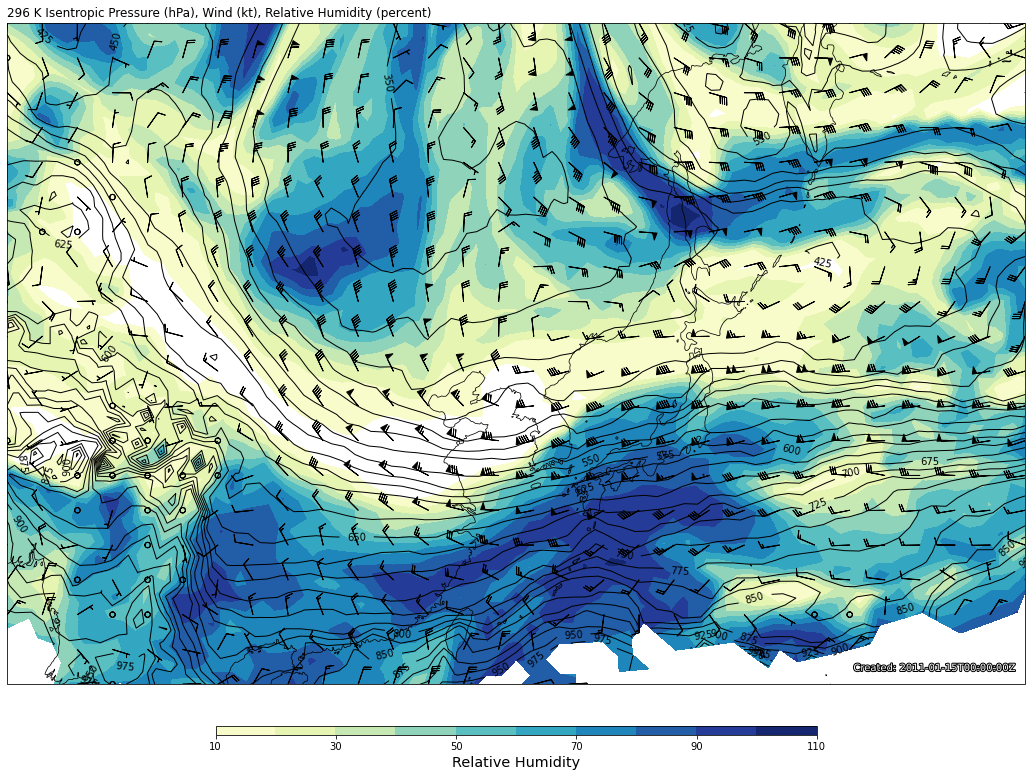

In [28]:
# Set up our projection
crs = ccrs.LambertConformal(central_longitude=125., central_latitude=30.0)

# Coordinates to limit map area
bounds = [(90., 160., 20., 60.)]
# Choose a level to plot, in this case 296 K
level = 0

fig = plt.figure(figsize=(17., 12.))
ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Plot the surface
clevisent = np.arange(0, 1000, 25)
cs = ax.contour(lon, lat, isentprs[level, :, :], clevisent,
                colors='k', linewidths=1.0, linestyles='solid', transform=ccrs.PlateCarree())
ax.clabel(cs, fontsize=10, inline=1, inline_spacing=7,
          fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot RH
cf = ax.contourf(lon, lat, isentrh[level, :, :], range(10, 115, 10),
                 cmap='YlGnBu', transform=ccrs.PlateCarree())
cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=0.5, pad=0.05)
cb.set_label('Relative Humidity', size='x-large')

# Plot wind barbs
ax.barbs(lon.values, lat.values, isentu[level, :, :].m, isentv[level, :, :].m, length=6,
         regrid_shape=20, transform=ccrs.PlateCarree())

# Make some titles
ax.set_title('{:.0f} K Isentropic Pressure (hPa), Wind (kt), Relative Humidity (percent)'
             .format(isentlevs[level].m), loc='left')
add_timestamp(ax, times.values.astype('datetime64[ms]').astype('O'),
              y=0.02, high_contrast=True)
fig.tight_layout()